In [87]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
import copy
import math

In [65]:



RAN_ACC = np.array([i for i in np.linspace(-.2, .2, 128)])

def compute_acceleration(acceleration):
    return acceleration + np.array([random.choice(RAN_ACC), random.choice(RAN_ACC), random.choice(RAN_ACC)])


def generate_data(initial_position, initial_velocity, initial_acceleration, time_step, num_steps):
    position = initial_position
    velocity = initial_velocity
    acceleration = initial_acceleration

    positions = np.array([])
    velocities = np.array([])
    accelerations = np.array([])
    n = len(initial_position)
    data = []

    # Initial
    positions = np.append(positions, position)
    velocities = np.append(velocities,velocity)
    accelerations = np.append(accelerations, acceleration)

    for _ in range(1, num_steps, 1):

        position += velocity * time_step
        velocity += acceleration * time_step
        acceleration = compute_acceleration(acceleration)

        positions = np.vstack([positions, position])
        velocities = np.vstack([velocities, velocity])
        accelerations = np.vstack([accelerations, acceleration])

    return  positions, velocities, accelerations


In [68]:
initial_position = np.array([1.0, 1.0, 1.0])
initial_velocity = np.array([1.0, 0.5, 0.0])
initial_acceleration = np.array([.5, .0, .5])
time_step = .2
num_steps = 100
positions, velocities, accelerations = generate_data(initial_position,initial_velocity,initial_acceleration,time_step, num_steps)

p = copy.deepcopy(positions)
v = copy.deepcopy(velocities)
a = copy.deepcopy(accelerations)

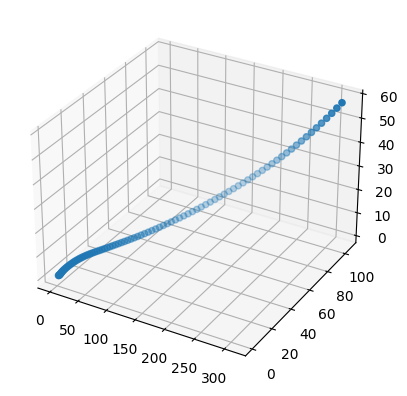

In [69]:
# Plotting positional data

x = positions[:,0]
y = positions[:, 1]
z = positions[:, 2]

fig = plt.figure()
actual = fig.add_subplot(111, projection='3d')
img = actual.scatter(x, y, z)
plt.show()

## Step by Step walk through

In [40]:
POS_VAR = np.array([i for i in np.linspace(-5, 5, 256)])
VEL_VAR = np.array([i for i in np.linspace(-.25, .25, 128)])
ACC_VAR = np.array([i for i in np.linspace(-.1, .1, 128)])

# Meant to vary the data to simulate measurement and error
def simulateMeasuredData(position, velocity, acceleration):

    # Vary Data
    n = len(position)
    for i in range(n):
        position[i] += random.choice(POS_VAR)
        velocity[i] += random.choice(VEL_VAR)
        acceleration[i] += random.choice(ACC_VAR)

    X = np.concatenate([position,velocity], axis=0).T

    # Get P matrix. Just random values to simulate an estimated error in the measurement
    P_pos = np.array([np.abs(random.choice(POS_VAR)), np.abs(random.choice(POS_VAR)), np.abs(random.choice(POS_VAR))])
    P_vel = np.array([np.abs(random.choice(VEL_VAR)), np.abs(random.choice(VEL_VAR)), np.abs(random.choice(VEL_VAR))])
    P_temp = np.concatenate([P_pos,P_vel])

    # No covariances because its an example so for simplicity all variables are independent
    P = np.identity((6)) 
    for i in range(6):
        P[i,i] = P_temp[i]
        
    return X, P, acceleration
        
def print_mat(mat):
    for line in mat:
        print("|", end=" ")
        for val in line:
            print("%.2f" % val,end="\t")
        print("|")


def getA(X, delta_t):
    n = len(X)
    mat = np.identity(n)
    for i in range((int)(n/2)):
        mat[i, i+3] = delta_t
    return mat

    
def getB(mat, delta_t):
    B = np.zeros((6,3))
    for i in range(3):
        B[i, i] = .5 * delta_t**2
    for i in range(3,6,1):
        B[i,i-3] = delta_t
    return B


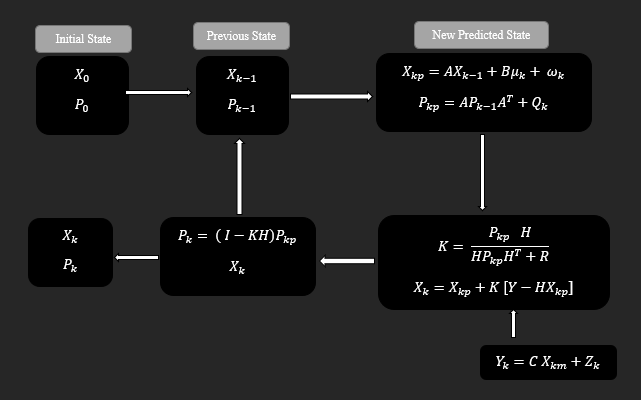

### Demonstration of one iteration of the above process

* Predicted State Step

In [70]:
X_0, P_0, mu_k = simulateMeasuredData(p[0], v[0], a[0])

In [71]:
A = getA(X_0, time_step)
B = getB(X_0, time_step)
mu = accelerations[0]

In [72]:
# New Predicted State
AX = np.dot(A, X_0)
Bmu = np.dot(B,mu)

X_kp = AX + Bmu # No omega because simplicity
# No Q value. Q should be some value accounting for error in calculating this prediction
P_kp = np.dot(np.dot(A,P_0), A.T) 


* Visualization of the process for the state matrix

In [73]:
print("A * X_0 + B * mu + omega\n")
print(X_0)
print("*")
print_mat(A)
print("+")
print_mat(B)
print("*")
print(mu)
print("=")
print(X_kp)

A * X_0 + B * mu + omega

[-0.47058824 -0.78431373 -1.45098039  1.04133858  0.31692913  0.08858268]
*
| 1.00	0.00	0.00	0.20	0.00	0.00	|
| 0.00	1.00	0.00	0.00	0.20	0.00	|
| 0.00	0.00	1.00	0.00	0.00	0.20	|
| 0.00	0.00	0.00	1.00	0.00	0.00	|
| 0.00	0.00	0.00	0.00	1.00	0.00	|
| 0.00	0.00	0.00	0.00	0.00	1.00	|
+
| 0.02	0.00	0.00	|
| 0.00	0.02	0.00	|
| 0.00	0.00	0.02	|
| 0.20	0.00	0.00	|
| 0.00	0.20	0.00	|
| 0.00	0.00	0.20	|
*
[0.5 0.  0.5]
=
[-0.25232052 -0.7209279  -1.42326386  1.14133858  0.31692913  0.18858268]


* Calculating Kalman Gain and X_k 

In [74]:
# Kalman Gain should be n X n with n being the size of X
# H is just a resizing matrix but in this case our P is the right size

# Get New Measurement
Y, R, acceleration = simulateMeasuredData(p[1], v[1], a[1])

In [75]:
temp1 = np.linalg.inv(P_kp + R)
K = np.dot(P_kp,temp1)

X_k = X_kp + np.dot(K, (Y - X_kp))

In [76]:
print(X_k)

[-3.31018615 -1.39054813  1.74596858  1.17169785  0.40824775  0.25988446]


* Update P_k
    * This step is very important because it updates how confident we are in our current value X_k. It says how confident we are mid process and whether we should be trusting it.

In [77]:
# Update P_k
P_k = np.dot((np.identity(K.shape[0]) - K), P_kp)

print_mat(P_k)

| 0.09	0.00	0.00	0.00	0.00	0.00	|
| 0.00	1.70	0.00	0.00	0.00	0.00	|
| 0.00	0.00	0.36	0.00	0.00	0.00	|
| 0.00	0.00	0.00	0.03	0.00	0.00	|
| 0.00	0.00	0.00	0.00	0.04	0.00	|
| 0.00	0.00	0.00	0.00	0.00	0.03	|


### Simulated Kalman Filter Loop

In [78]:
Xlist = []
Plist = []

X_k, P_k, mu_k = simulateMeasuredData(p[0], v[0], a[0])

Xlist.append(X_k)
Plist.append(P_k)

for i in range(1, num_steps):
    A = getA(X_k, time_step)
    B = getB(X_k, time_step)

    # New Predicted State
    X_kp = np.dot(A, X_k) + np.dot(B,mu_k)
    P_kp = np.dot(np.dot(A,P_k), A.T) 

    # Update w/ Measurement State
    Y, R, mu_k = simulateMeasuredData(p[i], v[i], a[i])
    K = np.dot(P_kp,np.linalg.inv(P_kp + R))
    X_k = X_kp + np.dot(K, (Y - X_kp))

    # Update P_k
    P_k = np.dot((np.identity(K.shape[0]) - K), P_kp)

    # Save output
    Xlist.append(X_k)
    Plist.append(P_k)     

## Analysis of results

* Plot of a portion of the data 

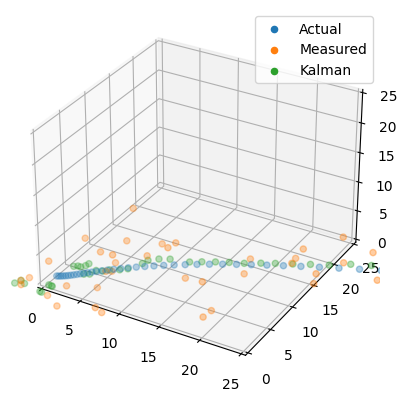

In [85]:
# Convert and graph output
est_position = np.array([])
est_position = np.append(est_position, np.array([0.0,0.0,0.0]))

for item in Xlist:
    est_position = np.vstack([est_position, np.array([item[0], item[1], item[2]])])

est_position = np.delete(est_position, 0,0)
est_x = est_position[:, 0]
est_y = est_position[:, 1]
est_z = est_position[:, 2]

meas_x = p[:, 0]
meas_y = p[:, 1]
meas_z = p[:, 2]

x_axis = (0, 25)
y_axis = (0, 25)
z_axis = (0, 25)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(x_axis)
ax.set_ylim(y_axis)
ax.set_zlim(z_axis)
ax.scatter(x, y, z, label="Actual")
ax.scatter(meas_x,meas_y, meas_z, label="Measured")
ax.scatter(est_x, est_y, est_z, label="Kalman")
ax.legend()
plt.show()

* Plot distances between kalman and real

In [86]:

distances = np.array([])
for i in range(num_steps):
    distances = np.append(distances, math.dist())

100
100
